In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm.notebook as tqdm

In [2]:
import matplotlib as mpl
plt.rcParams.update({
    "text.usetex": True})

In [28]:
def random_cov_matrix(d, alpha=1/3):
    """
    Generate a random covariance matrix according to annexe G1
    """
    k = int(np.round(d/alpha))
    M = np.random.normal(size=(k,d))
    A_tilde = M.T@M
    A = A_tilde / np.trace(A_tilde)
    return A

def random_cov_matrix_k(d, alpha=1/3):
    """
    Generate a random covariance matrix according to annexe G1
    """
    k = int(np.round(d/alpha))
    M = np.random.normal(size=(k,d))
    A_tilde = M.T@M
    A = A_tilde / k
    return A


import unittest

class TestRandom(unittest.TestCase):
    def test_random_cov_matrix(self):
        d = 13 
        A = random_cov_matrix(d)
        self.assertEqual(A.shape, (d,d))

unittest.main(argv=[''], verbosity=2, exit=False)

test_random_cov_matrix (__main__.TestRandom) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


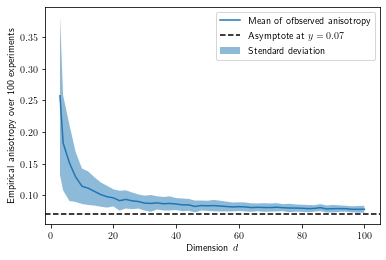

In [32]:
def plot_random_cov_matrix_eigenvalues(min_d=3, max_d=100, nb_points=50, exp_per_points=100):    
    dimensions = np.linspace(min_d, max_d, nb_points, dtype=np.int)
    mean = []
    std = []
    for d in tqdm.tqdm(dimensions):
        res = []
        for _ in range(exp_per_points):
            A = random_cov_matrix(d)
            #Min eigenvalue / Max eigenvalue
            ratio = np.linalg.cond(A, p=-2)
            res.append(ratio)
        mean.append(np.mean(res))
        std.append(np.std(res))
    mean = np.array(mean)
    std = np.array(std)
    plt.plot(dimensions, mean, label="Mean of ofbserved anisotropy")
    plt.axhline(y=0.07, color="black", linestyle="--", label="Asymptote at $y = 0.07$")
    plt.fill_between(dimensions, mean-std, mean+std, alpha=0.5, label="Stendard deviation")
    plt.ylabel(f"Empirical anisotropy over {exp_per_points} experiments")
    plt.xlabel("Dimension $d$")
    plt.legend()
    plt.savefig("images/anisotropy.svg")
    plt.savefig("images/anisotropy.png")
            
plot_random_cov_matrix_eigenvalues()

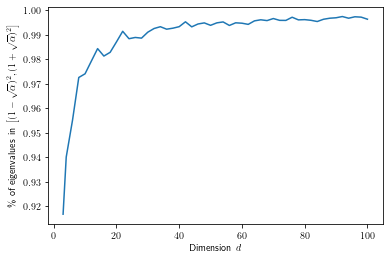

In [41]:
def plot_random_cov_matrix_eigenvalues(min_d=3, max_d=100, nb_points=50, exp_per_points=100, alpha = 1/3):    
    dimensions = np.linspace(min_d, max_d, nb_points, dtype=np.int)
    mean = []
    std = []
    int_min = (1 - np.sqrt(alpha))**2
    int_max = (1 + np.sqrt(alpha))**2
    for d in tqdm.tqdm(dimensions):
        res = []
        for _ in range(exp_per_points):
            k = int(np.round(d/alpha))
            M = np.random.normal(size=(k,d))
            A = M.T@M
            A = A / k
            eigs = np.linalg.eigvals(A)
            count = np.sum((int_min < eigs) & (eigs < int_max))
            res.append(count/d)
        mean.append(np.mean(res))
        #mean.append(np.mean(eigs))
        std.append(np.std(res))
    mean = np.array(mean)
    std = np.array(std)
    plt.plot(dimensions, mean)
    plt.ylabel("\% of eigenvalues in $\\left [ (1 - \\sqrt{\\alpha})^2,  (1 + \\sqrt{\\alpha})^2  \\right]$")
    plt.xlabel("Dimension $d$")
    plt.savefig("images/within_int.svg")
    plt.savefig("images/within_int.png")
            
plot_random_cov_matrix_eigenvalues()